Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from ucimlrepo import fetch_ucirepo
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error

Preprocess Dataset

In [2]:
def fetch_and_clean_adult_data(task_type):  
    # Fetch UCI Adult dataset
    adult = fetch_ucirepo(id=2)
    X = adult.data.features
    y = adult.data.targets.squeeze()  # Remove unnecessary axis
    
    # Clean the data
    X = X.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                      'hours-per-week': 'hours', 'marital-status': 'marital'})
    X = X.replace('?', pd.NA)  # Replace '?' with NaN
    X = X.dropna()  # Drop rows with missing values
    y = y.loc[X.index]
    
    # Map target labels for binary classification
    if task_type == 'classification':
        y = y.map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
    
    # Normalize numerical features
    numerical_features = ['age', 'fnlwgt', 'education-num', 'gain', 'loss', 'hours']
    scaler = MinMaxScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    # Encode categorical features
    X_encoded = pd.get_dummies(X).astype(float)
    
    return X_encoded.reset_index(drop=True), y.reset_index(drop=True)

Define Binary Classification Model

In [3]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Training the logistic regression model
def train_classification_model(X_train, y_train, input_dim, lr=0.1, epochs=10000):
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    
    loss_values = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

    # Plot loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

# Function to predict using the PyTorch model
def predict_classification_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        probabilities = model(X_tensor).squeeze()
        predictions = (probabilities >= 0.5).float()
    return predictions.numpy()


Define Regression Model

In [4]:
# Define a Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Same linear layer as logistic regression
    
    def forward(self, x):
        return self.linear(x)  # No activation function here for regression

# Training the linear regression model
def train_regression_model(X_train, y_train, input_dim, lr=0.1, epochs=10000):
    model = LinearRegressionModel(input_dim)
    criterion = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Convert training data to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    
    loss_values = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights
        loss_values.append(loss.item())

    # Plot loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

# Function to predict using the linear regression model
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_tensor).squeeze()
    return predictions.numpy()

Train and Evaluate generic (h_0) and personalized (h_p) models 

In [5]:
#################### Main Workflow ####################
def train_and_evaluate_model(task_type):
    # Step 1: Fetch, clean, and preprocess data
    X_encoded, y_cleaned = fetch_and_clean_adult_data(task_type)

    # Step 2: Split the data into training and testing sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_encoded, y_cleaned, test_size=0.3, random_state=42)
    excluded_columns = ['sex_Female', 'sex_Male']
    X_train_h0, X_test_h0 = X_train_hp.drop(columns=excluded_columns), X_test_hp.drop(columns=excluded_columns)

    if task_type == 'classification':
        print("Running classification task")
        print("Training and evaluating hp...")
        # HP
        model_hp = train_classification_model(X_train_hp, y_train, X_train_hp.shape[1])
        evaluate_model_classification(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")
        print("Training and evaluating h0...")
        # H0
        model_h0 = train_classification_model(X_train_h0, y_train, X_train_h0.shape[1])
        evaluate_model_classification(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    elif task_type == 'regression':
        print("Running regression task")
        print("Training and evaluating hp...")
        # HP
        model_hp = train_regression_model(X_train_hp, y_train, X_train_hp.shape[1])
        evaluate_model_regression(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")
        print("Training and evaluating h0...")
        # H0
        model_h0 = train_regression_model(X_train_h0, y_train, X_train_h0.shape[1])
        evaluate_model_regression(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

def evaluate_model_classification(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_classification_model(model, X_train)
    y_test_pred = predict_classification_model(model, X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Plot confusion matrix for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(test_cm).plot()
    plt.title(f'Confusion Matrix - Test Data ({model_name})')
    plt.show()

    # Print accuracy results
    print(f"Training Accuracy {model_name}: {train_accuracy:.4f}")
    print(f"Test Accuracy {model_name}: {test_accuracy:.4f}")

def evaluate_model_regression(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data using the predict_regression_model function
    y_train_pred = predict_model(model, X_train)
    y_test_pred = predict_model(model, X_test)

    # Calculate regression metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Plot predictions vs true values for test data
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predictions vs True Values - Test Data ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
    plt.show()

    # Print regression metrics
    print(f"{model_name} - Training MSE: {train_mse:.4f}")
    print(f"{model_name} - Test MSE: {test_mse:.4f}")


Find Results per Sex

In [6]:
# Function to filter data based on sex and calculate cost
def evaluate_model_for_sex(y_preds, y_val, sex_indices, cost_function):
    """
    Evaluate predictions for a specific sex group using a custom cost function (classification or regression).
    """
    # Use the provided sex indices to filter the predictions and true values
    y_sex_pred = y_preds[sex_indices]
    y_sex_val = y_val[sex_indices]

    # Compute the element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_sex_val, y_sex_pred)])
    total_loss = np.mean(individual_losses)

    return total_loss, y_sex_pred, y_sex_val

def evaluate_model_by_sex(y_preds, y_val, female_indices, male_indices, cost_function):
    """
    Evaluate predictions by sex using a custom cost function for classification or regression.
    """
    # Evaluate predictions for female subjects using pre-computed indices
    female_loss, female_preds, female_true = evaluate_model_for_sex(y_preds, y_val, female_indices, cost_function)

    # Evaluate predictions for male subjects using pre-computed indices
    male_loss, male_preds, male_true = evaluate_model_for_sex(y_preds, y_val, male_indices, cost_function)

    return female_loss, male_loss, (female_preds, female_true), (male_preds, male_true)

def compare_models_by_sex(y_preds_hp, y_preds_h0, X_test_hp, y_val_hp, y_val_h0, cost_function):
    """
    Compare two models' predictions by sex using a custom cost function for classification or regression.
    """
    # Calculate female and male indices based on X_test_hp (which has the sex columns)
    female_indices = X_test_hp['sex_Female'] == 1
    male_indices = X_test_hp['sex_Male'] == 1

    # Evaluate predictions from model 1 (h_p) using the indices from X_test_hp
    female_loss_model_1, male_loss_model_1, (female_preds_1, female_true_1), (male_preds_1, male_true_1) = evaluate_model_by_sex(
        y_preds_hp, y_val_hp, female_indices, male_indices, cost_function)

    # Evaluate predictions from model 2 (h_0) using the same indices applied to X_test_h_0
    female_loss_model_2, male_loss_model_2, (female_preds_2, female_true_2), (male_preds_2, male_true_2) = evaluate_model_by_sex(
        y_preds_h0, y_val_h0, female_indices, male_indices, cost_function)

    # Print results and calculate differences as before
    print(f"Model h_p - Female {cost_function.__name__}: {female_loss_model_1:.4f}, Male {cost_function.__name__}: {male_loss_model_1:.4f}")
    print(f"Model h_0 - Female {cost_function.__name__}: {female_loss_model_2:.4f}, Male {cost_function.__name__}: {male_loss_model_2:.4f}")

    return (female_loss_model_1, male_loss_model_1), (female_loss_model_2, male_loss_model_2)


Plot Individual Loss Differences per Sex

In [43]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, sex_indices, cost_function):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given sex using a custom cost function.
    """
    # Filter predictions and true values for the selected sex (male/female)
    y_preds_h0_filtered = y_preds_h0[sex_indices]
    y_preds_hp_filtered = y_preds_hp[sex_indices]
    y_vals_h0_filtered = y_val_h0[sex_indices]
    y_vals_hp_filtered = y_val_hp[sex_indices]
    

    # Compute individual element-wise losses using the custom cost function
    individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    return individual_diff

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for men and women using a custom element-wise cost function.
    """
    female_indices = X_test_hp['sex_Female'] == 1
    print("Number of females: ", sum(female_indices))
    male_indices = X_test_hp['sex_Male'] == 1
    print("Number of males", sum(male_indices))

    # Compute loss differences for females
    female_loss_diff = individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, female_indices, cost_function)
    
    # Compute loss differences for males
    male_loss_diff = individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, male_indices, cost_function)
    
    # Plot histogram for females
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(female_loss_diff, bins=30, alpha=0.7, color='blue')
    plt.title(f'{cost_function.__name__} Difference Histogram for Females for {title}')
    plt.xlabel('Difference in Loss/Accuracy')
    plt.ylabel('Frequency')
    
    # Plot histogram for males
    plt.subplot(1, 2, 2)
    plt.hist(male_loss_diff, bins=30, alpha=0.7, color='green')
    plt.title(f'{cost_function.__name__} Difference Histogram for Males for {title}')
    plt.xlabel('Difference in Loss/Accuracy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


Run Explainer, Comprehensiveness and Sufficiency

In [9]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


Define Cost Functions

In [33]:
def regression_cost_function(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

Full Run for Classification

Running classification task
Training and evaluating hp...


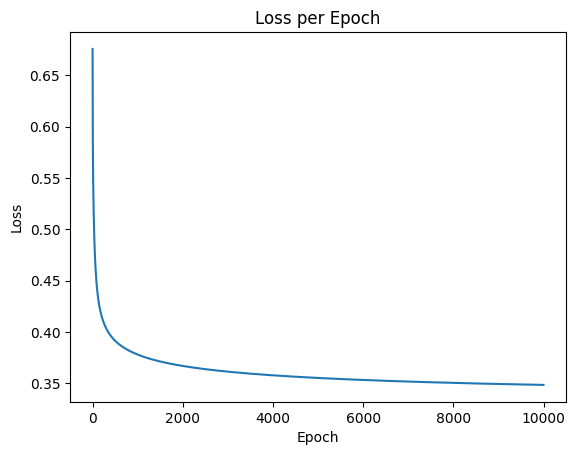

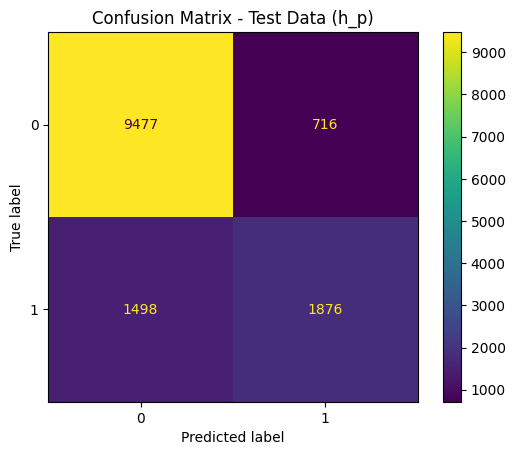

Training Accuracy h_p: 0.8366
Test Accuracy h_p: 0.8368
Training and evaluating h0...


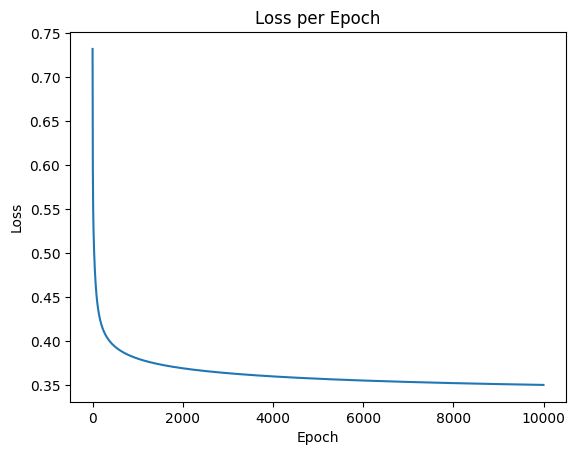

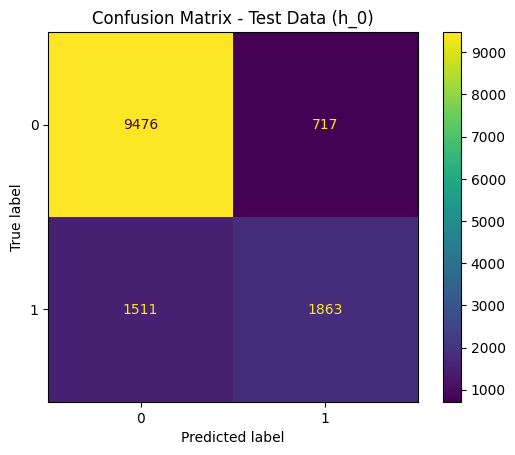

Training Accuracy h_0: 0.8363
Test Accuracy h_0: 0.8358


In [11]:
task_type = 'classification'
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model(task_type)

Model h_p - Female zero_one_loss: 0.0842, Male zero_one_loss: 0.2017
Model h_0 - Female zero_one_loss: 0.0842, Male zero_one_loss: 0.2032
Number of females:  4443
Number of males 9124


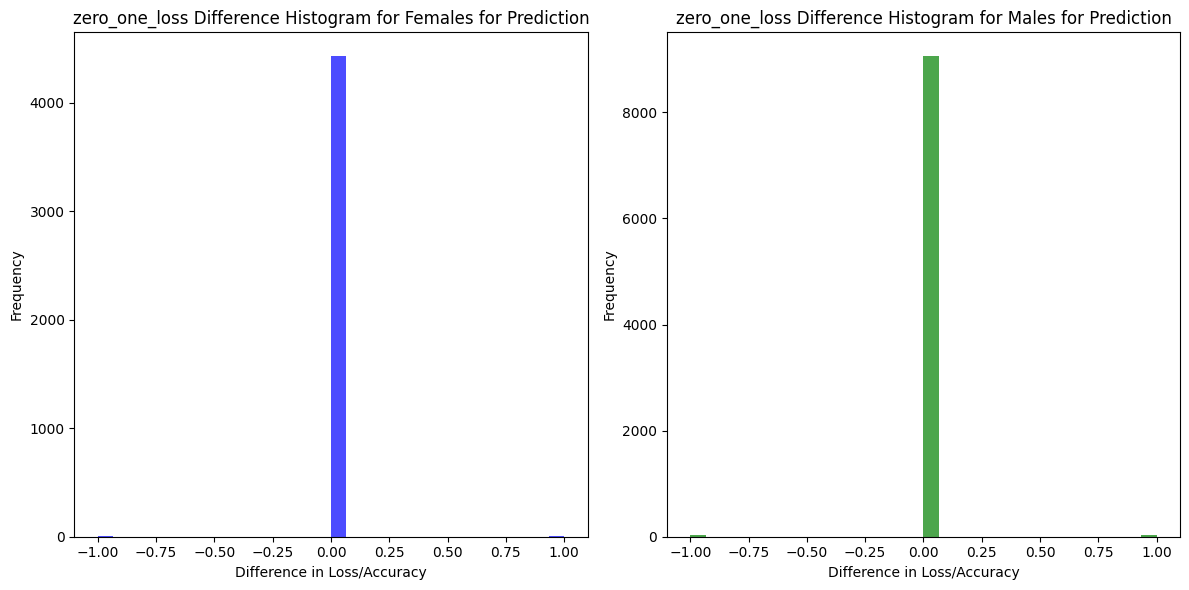

In [44]:
# Step 2: Generate predictions for both models
y_preds_hp = predict_model(model_hp, X_test_hp)
y_preds_h0 = predict_model(model_h0, X_test_h0)

# Assume true values for both models are the same, if not, you can handle them separately
y_test_hp = y_test
y_test_h0 = y_test
    
# Step 3: Compare models by sex using 0-1 loss function for classification
compare_models_by_sex(y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, zero_one_loss)

# Step 4: Plot loss difference histograms for normal model predictions using 0-1 loss
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, zero_one_loss, "Prediction")

In [13]:
# Step 5: Generate explanations with Integrated Gradients
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

Shape of attributions: torch.Size([13567, 104])
Shape of attributions: torch.Size([13567, 102])


Number of females:  4443
Number of males 9124


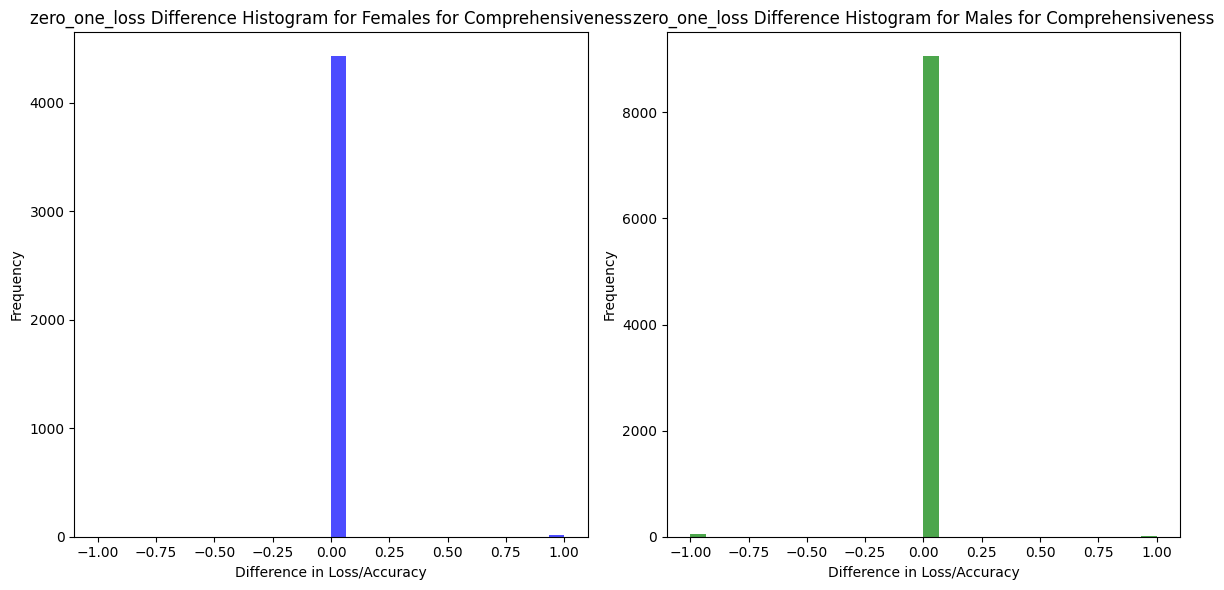

Number of females:  4443
Number of males 9124


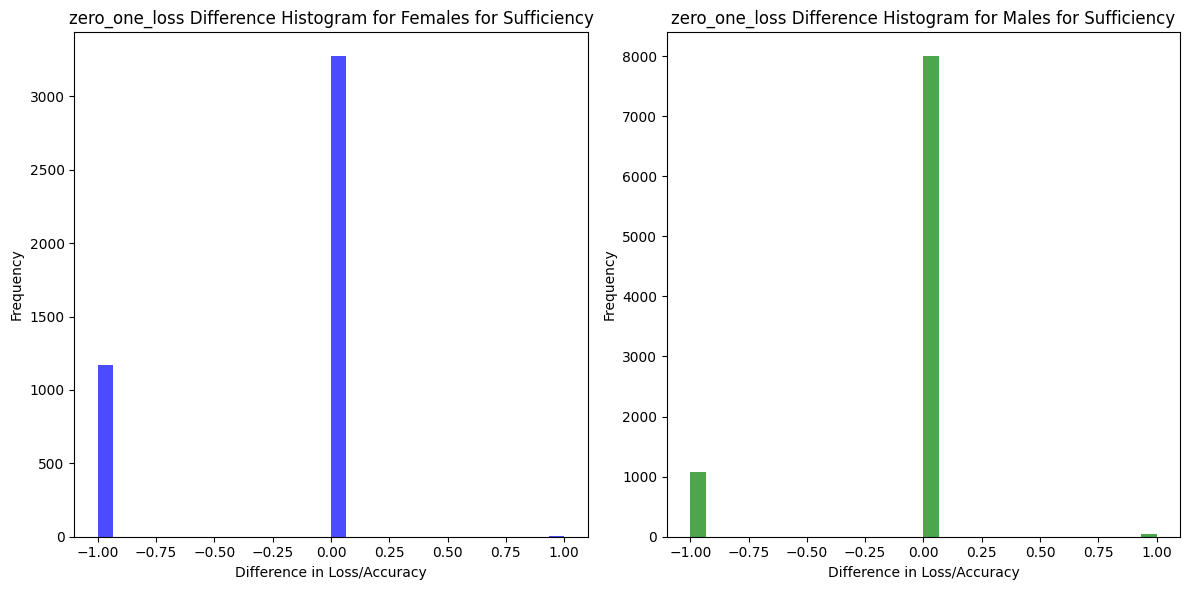

In [47]:
top_k = 50  # Adjust the number of top features to remove
comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
plot_loss_difference_histogram(comprehensiveness_preds_h0, comprehensiveness_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Comprehensiveness")

# Step 6: Calculate sufficiency predictions and plot loss differences using 0-1 loss
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Sufficiency")

In [ ]:
task_type = 'regression'
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model(task_type)